ENTROPHY © 2025 by Workfabric  
Licensed under Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International  
https://creativecommons.org/licenses/by-nc-sa/4.0/

## 1. Get Embeddings

This section will compute the embeddings for the process instances.

We provide the embeddings in CSV files for each domain, if you simply want to reproduce the figures, please go to Section 2 below.

In [1]:
import pandas as pd
import tiktoken
from openai import OpenAI
import numpy as np

In [2]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191
API_KEY = "API_KEY"

In [ ]:
PATH_TO_JSON = ""
df = pd.read_json(PATH_TO_JSON)

In [ ]:
df["text"] = (
    df.description
    + " in the screen "
    + df.screen_name
    + " of the application "
    + df.application_name
)

In [53]:
encoder = tiktoken.get_encoding(embedding_encoding)
client = OpenAI(api_key=API_KEY)

In [45]:
def get_embedding(text, model="text-embedding-3-small"):
    # Check if text is too large for the model's token limit
    tokens = encoder.encode(text)
    if len(tokens) <= max_tokens:
        # If text fits within token limit, get embedding directly
        return client.embeddings.create(input=[text], model=model).data[0].embedding
    else:
        # If text is too large, break it into chunks and average the embeddings
        chunks = []
        current_chunk = []
        current_length = 0

        # Split into chunks that fit within the token limit
        for token in tokens:
            if current_length + 1 > max_tokens:
                # Current chunk is full, add it to chunks and start a new one
                chunks.append(encoder.decode(current_chunk))
                current_chunk = [token]
                current_length = 1
            else:
                # Add token to current chunk
                current_chunk.append(token)
                current_length += 1

        # Add the last chunk if it's not empty
        if current_chunk:
            chunks.append(encoder.decode(current_chunk))

        # Get embeddings for each chunk
        chunk_embeddings = []
        for chunk in chunks:
            embedding = (
                client.embeddings.create(input=[chunk], model=model).data[0].embedding
            )
            chunk_embeddings.append(embedding)

        # Average the embeddings
        avg_embedding = np.mean(chunk_embeddings, axis=0).tolist()

        return avg_embedding

In [ ]:
# Create a new dataframe with process information
process_instances = []
for process_instance_uuid, group in df.groupby("process_instance_uuid"):
    process_name = group["process_name"].iloc[
        0
    ]  # Get process name from first row in group
    process_instance_text = "\n".join(group.text.tolist())
    process_instances.append(
        {
            "process_instance_uuid": process_instance_uuid,
            "process_name": process_name,
            "process_instance_text": process_instance_text,
        }
    )

process_df = pd.DataFrame(process_instances)
process_df

In [55]:
process_df["num_tokens"] = process_df.process_instance_text.apply(
    lambda x: len(encoder.encode(x))
)
process_df["embedding"] = process_df.process_instance_text.apply(
    lambda x: get_embedding(x, model="text-embedding-3-large")
)

In [ ]:
# # Save the process dataframe to CSV
# process_df.to_csv(f'CSV_PATH', index=False)

## 2. Generate Plots

This section uses the provided CSV files, which contains the embeddings for all process instances.

Please execute the cell below to produce the heatmaps of similarities.

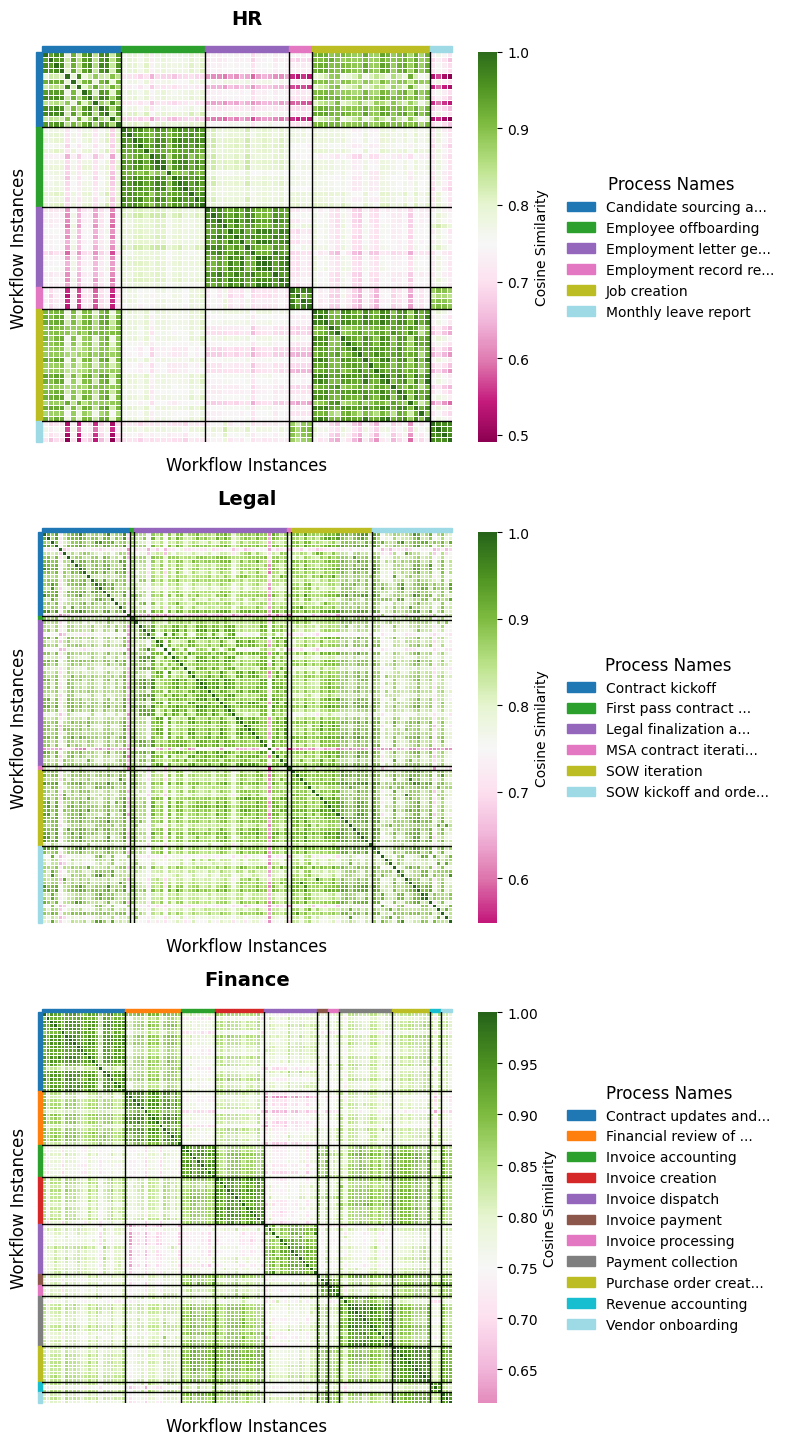

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

domains = ["hr", "legal", "finance"]
fig, axes = plt.subplots(3, 1, figsize=(8, 16))  # Adjusted for potentially wider labels

for i, domain in enumerate(domains):
    # Load embeddings
    embeddings_path = f"{domain}_embeddings.csv"
    embeddings_df = pd.read_csv(embeddings_path)
    process_names = embeddings_df["process_name"].tolist()

    # compute similarity matrix
    embeddings_array = np.array(
        embeddings_df.embedding.apply(lambda x: np.array(eval(x))).tolist()
    )
    similarity_matrix = cosine_similarity(embeddings_array)

    # Create a DataFrame for Seaborn's heatmap
    similarity_df = pd.DataFrame(
        similarity_matrix, index=process_names, columns=process_names
    )

    similarity_df_cleaned = similarity_df.dropna(axis=0, how="all").dropna(
        axis=1, how="all"
    )

    # Sort the DataFrame by process name
    similarity_df_sorted = similarity_df_cleaned.sort_index().sort_index(axis=1)

    # Get unique process names to create consolidated labels
    unique_processes = []
    unique_indices = []

    # Find the first occurrence of each unique process name
    for idx, process in enumerate(similarity_df_sorted.index):
        if len(process) > 20:
            process = process[:20] + "..."
        if process not in unique_processes:
            unique_processes.append(process)
            unique_indices.append(idx)

    # Plot the heatmap on the i-th subplot with increased font sizes
    g = sns.heatmap(
        similarity_df_sorted,
        ax=axes[i],
        cmap="PiYG",
        center=0.75,
        linewidths=0.4,
        cbar_kws={"label": "Cosine Similarity"},
    )

    if domain == "hr":
        axes[i].set_title("HR", fontsize=14, fontweight="bold", pad=20)
    else:
        axes[i].set_title(
            f"{domain.capitalize()}", fontsize=14, fontweight="bold", pad=20
        )
    axes[i].set_xlabel("Workflow Instances", fontsize=12, labelpad=10)
    axes[i].set_ylabel("Workflow Instances", fontsize=12, labelpad=10)

    # Hide all tick labels first
    axes[i].set_xticks([])
    axes[i].set_yticks([])

    # Create a mapping of process names to indices
    process_indices = {}
    for j, process in enumerate(unique_processes):
        process_indices[process] = j

    # Add process labels as annotations instead of tick labels
    # Create a separate legend/key figure for process names
    process_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_processes)))

    # Add colored blocks at the edges of the heatmap
    for j in range(len(unique_indices)):
        start_idx = unique_indices[j]
        end_idx = (
            unique_indices[j + 1]
            if j < len(unique_indices) - 1
            else len(similarity_df_sorted)
        )
        width = end_idx - start_idx

        # Add colored rectangles at the top and left edges
        rect_color = process_colors[j]

        # Top edge - make thicker
        axes[i].add_patch(
            plt.Rectangle(
                (start_idx, -1.0),
                width,
                1.0,
                fill=True,
                color=rect_color,
                clip_on=False,
            )
        )
        # Left edge - make thicker
        axes[i].add_patch(
            plt.Rectangle(
                (-1.0, start_idx),
                1.0,
                width,
                fill=True,
                color=rect_color,
                clip_on=False,
            )
        )

    # Add a legend below each heatmap with larger font size
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, color=process_colors[j])
        for j in range(len(unique_processes))
    ]

    # Create a more readable legend to the right of the heatmap
    axes[i].legend(
        legend_elements,
        unique_processes,
        loc="center left",
        bbox_to_anchor=(1.25, 0.5),
        fontsize=10,
        frameon=False,
        ncol=1,
        title="Process Names",
        title_fontsize=12,
    )

    # Add thicker lines to separate different processes
    for idx in unique_indices[1:]:  # Skip the first index
        # Add horizontal and vertical lines
        axes[i].axhline(y=idx, color="black", linestyle="-", linewidth=1)
        axes[i].axvline(x=idx, color="black", linestyle="-", linewidth=1)

plt.tight_layout(
    rect=[0, 0.05, 1, 0.96]
)  # Adjust layout for suptitle and x-axis labels

# Save the figure to PDF
plt.savefig("process_similarity_heatmap.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)